# Data Loading and Generation

In [ ]:
import os
if "aesthetix.py" not in os.popen("ls").read():
  !wget https://raw.githubusercontent.com/Stellarator-X/ConvoBot/servus/Programming%20Assignments/Speech%20Recognition/ds_utils/aesthetix.py
import numpy as np 
from sklearn.model_selection import train_test_split
import aesthetix as at

# Downloading movie_lines
if "movie_lines.txt" not in os.popen("ls").read():
  !wget https://raw.githubusercontent.com/Stellarator-X/ConvoBot/servus/Programming%20Assignments/Response%20Generation/movie_lines.txt

movielines = open("movie_lines.txt", mode='r')
print(movielines)
lines = movielines.readlines()
print(len(lines))

def clean_str(_str):
  _str = _str.strip()
  _str = _str.lower()
  _str = _str.replace(".", "")
  _str = _str.replace(",", "")
  _str = _str.replace("?", "")
  _str = _str.replace("!", "")
  _str = _str.replace(":", "")
  _str = _str.replace("-", " ")
  _str = _str.replace("_", " ")
  _str = _str.replace("\\", "")
  _str = _str.replace("  ", " ")
  return _str



<_io.TextIOWrapper name='movie_lines.txt' mode='r' encoding='UTF-8'>
304713


In [ ]:
sample_size = 20000
cleanlines = []
for i, line in enumerate(lines[:sample_size]):
  at.progress_bar("Cleaning the lines", i, len(lines[:sample_size]))
  speaker, line = line.split('+++$+++ ')[-2:]
  cleanlines.append([speaker.split(" ")[0], line.split('\n')[0]])

cleanlines.reverse()
cleanlines = np.array(cleanlines)
for line in cleanlines[:10]:
  print(line[0],":",line[1])


# Forming the dataset 
response_data = []
l = len(cleanlines)-1
for i, line in enumerate(cleanlines[:-1]):
  at.progress_bar("Generating Stimulus-Response Pairs", i, l)
  speaker, utterance = line
  next_speaker, next_utterance = cleanlines[i+1]
  if speaker is not next_speaker:
    response_data.append(np.array(["<start> "+clean_str(utterance)+" <end>", "<start> "+clean_str(next_utterance)+" <end>"]))
  
response_data = np.array(response_data)
print(response_data.shape)
print(response_data[-10:])

Cleaning the lines:[==============================](100.00%)  
PRINCESS : Sir, I... come to beg you to confess all, and swear allegiance to the king, that he might show you mercy.
WALLACE : Will he show mercy to my country? Will he take back his soldiers, and let us rule ourselves?
PRINCESS : Mercy... is to die quickly. Perhaps even live in the Tower. In time, who knows what can happen, if you can only live.
WALLACE : If I swear to him, then everything I am is dead already.
PRINCESS : You will die! It will be awful!
WALLACE : Every man dies. Not every man really lives.
PRINCESS : Drink this! It will dull your pain.
WALLACE : It will numb my wits, and I must have them all. If I'm senseless, or if I wail, then Longshanks will have broken me.
PRINCESS : I can't bear the thought of your torture. Take it!
NICOLETTE : When the king returns he will bury them in those new clothes. Scotland is in chaos. Your husband is secretly sending an army north.
Generating Stimulus-Response Pairs:[========

In [ ]:
# import pandas as pd
# a = pd.DataFrame({'Context': response_data[:, 0], 'Responses': response_data[:, 1]})
# a.to_csv("Dat.csv")

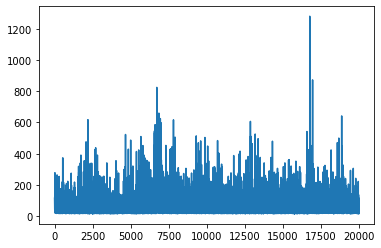

64.51767588379418
Longest utterance :  <start> you've got penthouse playboy hustler etc nobody even considers them pornography anymore then there's mainstream hardcore triple x the difference is penetration that's hardcore that whole industry's up in the valley writers directors porn stars they're celebrities or they think they are they pump out 150 videos a week a week they've even got a porno academy awards america loves pornography anybody tells you they never use pornography they're lying somebody's buying those videos somebody's out there spending 900 million dollars a year on phone sex know what else it's only gonna get worse more and more you'll see perverse hardcore coming into the mainstream because that's evolution desensitization oh my god elvis presley's wiggling his hips how offensive nowadays mtv's showing girls dancing around in thong bikinis with their asses hanging out know what i mean for the porn addict big tits aren't big enough after a while they have to be the big

In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline
a = [len(s) for s in response_data[:,0]]
# a_ = [s for s in response_data[:,0] if len(s)>2000]
plt.plot(a)
plt.show()
print(np.mean(np.array(a)))
print("Longest utterance : ", response_data[np.argmax(a), 0])

In [ ]:
# Preprocessing the Data
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

oov_token = "<OOV>"
max_length = 25
stimuli = response_data[:, 0]
responses = response_data[:, 1]

tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(stimuli)

word_index = tokenizer.word_index
word_index['<start>'] = 0
word_index['<end>'] = len(word_index)+1
index_word = {word_index[word]:word for word in word_index}
vocab_size = len(word_index)
stimulus_sequences = tokenizer.texts_to_sequences(stimuli)
response_sequences = tokenizer.texts_to_sequences(responses)

padded_stimulus_sequences = pad_sequences(stimulus_sequences, maxlen = max_length ,padding = 'post', truncating = 'post')
padded_response_sequences = pad_sequences(response_sequences, maxlen = max_length, padding = 'post', truncating = 'post')


In [ ]:
index_word[1829]

'confess'

In [ ]:
# Getting the embedding weights from pre-trained glove vectors
embedding_dim = 100

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-06-21 11:38:09--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 2a00:1450:4013:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  97.4MB/s    in 3.4s    

2020-06-21 11:38:13 (97.4 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



# Encoder-Decoder with Attention


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Bidirectional, Embedding, LSTM, RepeatVector, Concatenate, Dot, Activation, Input
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
print(tf.__version__)
%matplotlib inline

2.2.0


In [ ]:
BATCH_SIZE = 500
BUFFER_SIZE = len(padded_response_sequences)
num_dat_sets = 1
steps_per_epoch = BUFFER_SIZE//(BATCH_SIZE*num_dat_sets)
embedding_dims = 256
rnn_units = 1024
dense_units = 1024
Dtype = tf.float32   #used to initialize DecoderCell Zero state
Tx = max_length
Ty = max_length

In [ ]:
BUFFER_SIZE

19999

In [ ]:
# Initialising the dataset
num_dats = BUFFER_SIZE // num_dat_sets
datasets = [tf.data.Dataset.from_tensor_slices((padded_stimulus_sequences[i*num_dats:(i+1)*num_dats], padded_response_sequences[i*num_dats:(i+1)*num_dats])).shuffle(num_dats).batch(BATCH_SIZE, drop_remainder=True) for i in range(num_dat_sets) ]
example_X, example_Y = next(iter(datasets[0]))
print(example_X.shape) 
print(example_Y.shape)

(500, 25)
(500, 25)


In [ ]:
class EncoderNet(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units, embeddings_matrix):
    super(EncoderNet, self).__init__()
    self.encoder_embedding = tf.keras.layers.Embedding(input_dim = vocab_size+1,
                                                       output_dim = embedding_dim,
                                                       weights = [embeddings_matrix], trainable = False)
    self.encoder_rnnlayer = tf.keras.layers.LSTM(rnn_units,return_sequences = True, return_state = True)
  
# Decoder
class DecoderNet(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units, embeddings_matrix):
    super(DecoderNet, self).__init__()
    self.decoder_embedding = tf.keras.layers.Embedding(input_dim = vocab_size+1,
                                                       output_dim = embedding_dim, weights = [embeddings_matrix], trainable= False)
    self.dense_layer = Dense(vocab_size)
    self.decoder_rnncell = tf.keras.layers.LSTMCell(rnn_units)
    #Sampler
    self.sampler = tfa.seq2seq.sampler.TrainingSampler()

    self.attention_mechanism = self.build_attention_mechanism(dense_units, None, BATCH_SIZE*[Tx])
    self.rnn_cell = self.build_rnn_cell(BATCH_SIZE)
    self.decoder  = tfa.seq2seq.BasicDecoder(self.rnn_cell, sampler = self.sampler, output_layer = self.dense_layer)
  
  def build_attention_mechanism(self, units, memory, memory_sequence_length):
    return tfa.seq2seq.LuongAttention(units, memory= memory, memory_sequence_length=memory_sequence_length)
  
  def build_rnn_cell(self, batch_size):
    rnn_cell = tfa.seq2seq.AttentionWrapper(self.decoder_rnncell, self.attention_mechanism, attention_layer_size = dense_units)
    return rnn_cell
  
  def build_decoder_initial_state(self, batch_size, encoder_state, Dtype):
    decoder_initial_state = self.rnn_cell.get_initial_state(batch_size = batch_size, dtype = Dtype)
    decoder_initial_state = decoder_initial_state.clone(cell_state =encoder_state)
    return decoder_initial_state 
  


In [ ]:
encoderNet = EncoderNet(vocab_size, embedding_dim, rnn_units, embeddings_matrix)
decoderNet = DecoderNet(vocab_size, embedding_dim, rnn_units, embeddings_matrix)


In [ ]:
optimizer = tf.keras.optimizers.Adam()

In [ ]:
def loss_function(y_pred, y):
  #shape of y [batch_size, ty]
  #shape of y_pred [batch_size, Ty, output_vocab_size] 
  sparsecategoricalcrossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                                                reduction='none')
  loss = sparsecategoricalcrossentropy(y_true=y, y_pred=y_pred)
  #skip loss calculation for padding sequences i.e. y = 0 
  
  # mask the loss when padding sequence appears in the output sequence
  mask = tf.logical_not(tf.math.equal(y,0))   #output 0 for y=0 else output 1
  mask = tf.cast(mask, dtype=loss.dtype)
  loss = mask* loss
  loss = tf.reduce_mean(loss)
  return loss

In [ ]:
decoderNet.attention_mechanism.memory_initialized

False

In [ ]:
def train_step(input_batch, output_batch, encoder_initial_cell_state):
  loss = 0
  with tf.GradientTape() as tape:
      encoder_emb_inp = encoderNet.encoder_embedding(input_batch)
      a, a_tx, c_tx = encoderNet.encoder_rnnlayer(encoder_emb_inp, 
                                                      initial_state =encoder_initial_cell_state)

      #[last step activations,last memory_state] of encoder passed as input to decoder Network
      
        
      # Prepare correct Decoder input & output sequence data
      decoder_input = output_batch[:,:-1] # ignore <end>
      #compare logits with timestepped +1 version of decoder_input
      decoder_output = output_batch[:,1:] #ignore <start>


      # Decoder Embeddings
      decoder_emb_inp = decoderNet.decoder_embedding(decoder_input)

      #Setting up decoder memory from encoder output and Zero State for AttentionWrapperState
      decoderNet.attention_mechanism.setup_memory(a)
      decoder_initial_state = decoderNet.build_decoder_initial_state(BATCH_SIZE,
                                                                          encoder_state=[a_tx, c_tx],
                                                                          Dtype=tf.float32)
      
      #BasicDecoderOutput        
      outputs, _, _ = decoderNet.decoder(decoder_emb_inp,initial_state=decoder_initial_state,
                                              sequence_length=BATCH_SIZE*[Ty-1])

      logits = outputs.rnn_output
      #Calculate loss

      loss = loss_function(logits, decoder_output)

  #Returns the list of all layer variables / weights.
  variables = encoderNet.trainable_variables + decoderNet.trainable_variables  
  # differentiate loss wrt variables
  gradients = tape.gradient(loss, variables)

  #grads_and_vars – List of(gradient, variable) pairs.
  grads_and_vars = zip(gradients,variables)
  optimizer.apply_gradients(grads_and_vars)
  return loss

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True )

In [ ]:
# Training
checkpoint_path = "ResponseModel/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
check_prefix = os.path.join(checkpoint_dir, "checkpt")

checkpoint = tf.train.Checkpoint(optimizer = optimizer, encoderNet = encoderNet, decoderNet = decoderNet)


In [ ]:
def initialize_initial_state():
        return [tf.zeros((BATCH_SIZE, rnn_units)), tf.zeros((BATCH_SIZE, rnn_units))]

In [ ]:
vocab_size

12954

In [ ]:
def fit_mod(dataset, epochs, history, verbose = True, save_check = False):
  print("Training :")
  for i in range(1, epochs+1):
    encoder_initial_cell_state = initialize_initial_state()
    total_loss = 0.0
    disp_loss = 0.0
    for ( batch , (input_batch, output_batch)) in enumerate(dataset.take(steps_per_epoch)):
      if verbose : at.progress_bar(f"Epoch {i}/{epochs}", batch, steps_per_epoch, output_vals = {'Loss' : disp_loss})
      batch_loss = train_step(input_batch, output_batch, encoder_initial_cell_state)
      total_loss += batch_loss
      disp_loss = total_loss/(max(batch, 1))
    # Save checkpoint:
    if save_check:
      print(f"Saving checkpoint at {checkpoint_path}")
      checkpoint.save(file_prefix=check_prefix)
    history.append(disp_loss)

In [ ]:
loss_history = []

Training :
Epoch 1/30:[==============================](100.00%)  Loss : 2.84 
Epoch 2/30:[==============================](100.00%)  Loss : 2.60 
Epoch 3/30:[==============================](100.00%)  Loss : 2.54 
Epoch 4/30:[==============================](100.00%)  Loss : 2.47 
Epoch 5/30:[==============================](100.00%)  Loss : 2.40 
Epoch 6/30:[==============================](100.00%)  Loss : 2.34 
Epoch 7/30:[==============================](100.00%)  Loss : 2.29 
Epoch 8/30:[==============================](100.00%)  Loss : 2.23 
Epoch 9/30:[==============================](100.00%)  Loss : 2.19 
Epoch 10/30:[==============================](100.00%)  Loss : 2.14 
Epoch 11/30:[==============================](100.00%)  Loss : 2.09 
Epoch 12/30:[==============================](100.00%)  Loss : 2.03 
Epoch 13/30:[==============================](100.00%)  Loss : 1.98 
Epoch 14/30:[==============================](100.00%)  Loss : 1.92 
Epoch 15/30:[==============================](1

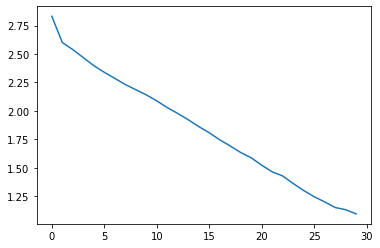

In [ ]:
fit_mod(datasets[0], 30, loss_history)
plt.plot(loss_history)

# Beam Search

In [ ]:
checkpoint.save(file_prefix = check_prefix)

In [ ]:
# !zip -r  ResponseModel_s2s.zip ResponseModel

In [ ]:
# import re
# [print(var) for var in tf.train.list_variables(
#     checkpoint_dir)]

In [ ]:
decoder_embedding_matrix = tf.train.load_variable(
    checkpoint_dir, 'decoderNetwork/decoder_embedding/embeddings/.ATTRIBUTES/VARIABLE_VALUE')
print(decoder_embedding_matrix.shape)

In [ ]:
beam_width = 3

sample_lines = ["Hello","Have you trained the Model?", "who are you", "I got "]
sample_lines = [clean_str(line) for line in sample_lines]

sample_sequences  = tokenizer.texts_to_sequences(sample_lines)
padded_sample_sequences = pad_sequences(sample_sequences, max_length, padding = "post", truncating = 'post')

inp = tf.convert_to_tensor(padded_sample_sequences, dtype = Dtype)
inference_batch_size = len(sample_lines)

encoder_initial_cell_state = [tf.zeros((inference_batch_size, rnn_units)),
                              tf.zeros((inference_batch_size, rnn_units))]
encoder_emb_inp = encoderNet.encoder_embedding(inp)
a, a_tx, c_tx = encoderNet.encoder_rnnlayer(encoder_emb_inp,
                                                initial_state =encoder_initial_cell_state)

start_tokens = tf.fill([inference_batch_size],word_index['<start>'])
#print(start_tokens)
end_token = word_index['<end>']



decoder_input = tf.expand_dims([word_index['<start>']]* inference_batch_size,1)
decoder_emb_inp = decoderNet.decoder_embedding(decoder_input)


#From official documentation
#NOTE If you are using the BeamSearchDecoder with a cell wrapped in AttentionWrapper, then you must ensure that:

#The encoder output has been tiled to beam_width via tfa.seq2seq.tile_batch (NOT tf.tile).
#The batch_size argument passed to the get_initial_state method of this wrapper is equal to true_batch_size * beam_width.
#The initial state created with get_initial_state above contains a cell_state value containing properly tiled final state from the encoder.
encoder_memory = tfa.seq2seq.tile_batch(a, beam_width)
decoderNet.attention_mechanism.setup_memory(encoder_memory)
print("beam_with * [batch_size, Tx, rnn_units] :  3 * [2, Tx, rnn_units]] :", encoder_memory.shape)
#set decoder_inital_state which is an AttentionWrapperState considering beam_width
decoder_initial_state = decoderNet.rnn_cell.get_initial_state(batch_size = inference_batch_size* beam_width,dtype = Dtype)
encoder_state = tfa.seq2seq.tile_batch([a_tx, c_tx], multiplier=beam_width)
decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state) 

decoder_instance = tfa.seq2seq.BeamSearchDecoder(decoderNet.rnn_cell,beam_width=beam_width,
                                                 output_layer=decoderNet.dense_layer)


# Since we do not know the target sequence lengths in advance, we use maximum_iterations to limit the translation lengths.
# One heuristic is to decode up to two times the source sentence lengths.
maximum_iterations = tf.round(tf.reduce_max(Tx) * 2)

#initialize inference decoder

(first_finished, first_inputs,first_state) = decoder_instance.initialize(decoder_embedding_matrix,
                             start_tokens = start_tokens,
                             end_token=end_token,
                             initial_state = decoder_initial_state)
#print( first_finished.shape)
print("\nfirst_inputs returns the same decoder_input i.e. embedding of  <start> :",first_inputs.shape)

inputs = first_inputs
state = first_state  
predictions = np.empty((inference_batch_size, beam_width,0), dtype = np.int32)
beam_scores =  np.empty((inference_batch_size, beam_width,0), dtype = np.float32)                                                                            
for j in range(maximum_iterations):
    beam_search_outputs, next_state, next_inputs, finished = decoder_instance.step(j,inputs,state)
    inputs = next_inputs
    state = next_state
    outputs = np.expand_dims(beam_search_outputs.predicted_ids,axis = -1)
    scores = np.expand_dims(beam_search_outputs.scores,axis = -1)
    predictions = np.append(predictions, outputs, axis = -1)
    beam_scores = np.append(beam_scores, scores, axis = -1)
print(predictions.shape) 
print(beam_scores.shape)

beam_with * [batch_size, Tx, rnn_units] :  3 * [2, Tx, rnn_units]] : (9, 25, 1024)

first_inputs returns the same decoder_input i.e. embedding of  <start> : (3, 3, 100)
(3, 3, 50)
(3, 3, 50)


In [ ]:
import itertools
print("Stimuli:")
for line in sample_lines :
  print(line)
print("Responses")
for i in range(len(predictions)):
  output_beams_per_sample = predictions[i,:,:]
  score_beams_per_sample = beam_scores[i,:,:]
  for beam, score in zip(output_beams_per_sample,score_beams_per_sample) :
    seq = list(itertools.takewhile( lambda index: index !=3, beam))
    score_indexes = np.arange(len(seq))
    beam_score = score[score_indexes].sum()/len(seq)
    print(" ".join( [index_word[w] for w in seq]), " beam score: ", beam_score)
  print()

Stimuli:
hello
have you trained the model
who are you
Responses
yes  beam score:  -1.7373862266540527
oh  beam score:  -2.6385703086853027
i come on i'm is of  beam score:  -6.087005615234375

yes  beam score:  -1.6268314123153687
i was a now  beam score:  -3.6284029483795166
it's sir the favor the now town now now  beam score:  -6.82769054836697

i was  beam score:  -1.7875832319259644
i'm  beam score:  -2.573168992996216
and wasn't thinking i know you hoping is her  beam score:  -6.750890943739149

